# Experiment 4 - Heirarichal clustering - K Means 
#### Optimal K (no of clusters) discovery
#### Clustering based on Min,Max and Avg
#### Clustering Visualization

In [1]:
from sklearn.cluster import KMeans as kmn
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import copy
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, is_valid_linkage


## Part - 1

## Using k-means to create clusters

In [2]:
df = pd.read_fwf("dim032.txt",delimiter=" ")

print(df.head())
print(df.shape)

   84  152  100  52   95  186  169  106  37  186.1  ...  190  65  214  116  \
0  86  149  101  56   93  181  171  116  37    192  ...  191  79  215  116   
1  83  149   99  51   96  187  169  108  34    191  ...  190  65  213  118   
2  86  142  101  64  105  183  172  116  49    180  ...  186  69  209  120   
3  89  145  108  54   91  180  175  107  35    192  ...  188  67  212  118   
4  84  152  100  52   96  187  171  109  38    187  ...  190  64  216  114   

   75  55.1  123  65.1  154  177  
0  76    60  130    71  151  181  
1  73    55  125    63  155  178  
2  68    56  123    67  144  181  
3  91    50  135    58  147  165  
4  76    54  124    64  153  176  

[5 rows x 32 columns]
(1023, 32)


Text(0, 0.5, 'SSE values')

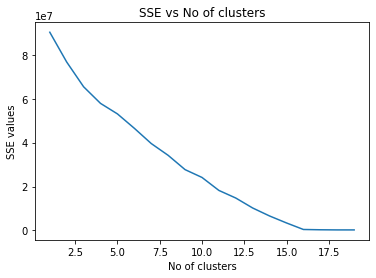

In [3]:
sse_Error = []

for i in range(1,20):

    kmeans = kmn(n_clusters=i).fit(df)
    kmeans.fit(df)

    sse_Error.append(kmeans.inertia_)


#Plotting the error to no of clusters

plt.plot(range(1,20),sse_Error)
plt.title("SSE vs No of clusters")
plt.xlabel("No of clusters")
plt.ylabel("SSE values")

# K = 16 is the end of the elbow. Therefore this value will be used to be the optimal cluster value. 

In [4]:
kmeans = kmn(n_clusters=16)

kmeans.fit(df)
labels = kmeans.labels_

# print("Labels:",set(kmeans.labels_))
print(labels.shape)


(1023,)


# Heirarchial clustering
### Using the created clusters through k-means. We use hierarichal clustering to to perform clustering on the rest of the clusters

In [5]:
# Creation of a dictionary to hold the cluster indexes

clusters_labels = {}


#The dictionary holds the 

labels = list(kmeans.labels_)

for i in labels:
    clusters_labels[i]= i

cluster_map_max = copy.deepcopy(clusters_labels)
cluster_map_avg = copy.deepcopy(clusters_labels)
cluster_map_min = copy.deepcopy(clusters_labels)

# print(clusters_labels)


In [6]:
labels = list(kmeans.labels_)
df= np.c_[df, labels ]
print((df.shape))

(1023, 33)


In [7]:
#Extracting datapoints values and clustering them based on their classified group
# Using dictionary for easy call up
clusters_labeled = defaultdict(list)

for x in df:
    j = x[0:31].tolist()
    clusters_labeled[int(x[32])].append(j)

In [8]:
# A dictionary to hold all the distance values b/w points in the dataset
dictionary = defaultdict(dict)

for i in clusters_labeled.keys():
    for j in clusters_labeled.keys():
        dictionary[int(i)][int(j)] = 9999999

for i in clusters_labeled.keys():
    for j in clusters_labeled.keys():
        for k in clusters_labeled[i]:
            for l in clusters_labeled[j]:
                dictionary[int(i)][int(j)] = min(dictionary[int(i)][int(j)],np.sqrt(np.sum(np.power((np.array(k)-np.array(l)),2))))

In [9]:
#Removing the same values in the diagonal to prevent closest clusters

for i in list(dictionary):
    for j in list(dictionary[i]):
        if(i==j):
            del dictionary[int(i)][int(j)]

In [10]:
#Assigning every cluster to level 1, will update these cluster levels as they get combined to form larger clusters 

cluster_list = list(clusters_labeled.keys())
cluster_count = {}
for i in clusters_labeled.keys():
    cluster_count[i] = 1

cluster_count_max = copy.deepcopy(cluster_count)
cluster_count_avg = copy.deepcopy(cluster_count)


In [11]:
# Making copies of cluster to keep into account for both avg and max functions 
cluster_list_max = copy.deepcopy(cluster_list)
cluster_list_avg = copy.deepcopy(cluster_list)

In [12]:
#Making copies of the dictionary holding classifcications of each datapoint

dictionary_max = copy.deepcopy(dictionary)
dictionary_avg = copy.deepcopy(dictionary)
dictionary_min = copy.deepcopy(dictionary)

In [13]:
def lance_williams_dist(ci,cj,ck,d,alpha1,alpha2,beta,gamma):
    if(ci!=cj and cj!=ck and ci!=ck):
        d[(ci,cj)][ck] = alpha1*d[ci][ck] + alpha2*d[cj][ck] + beta*d[ci][cj] + gamma*abs(d[ci][ck]-d[cj][ck])
        d[ck][(ci,cj)] = alpha1*d[ci][ck] + alpha2*d[cj][ck] + beta*d[ci][cj] + gamma*abs(d[ci][ck]-d[cj][ck])
        

In [14]:
#  Using 

c1 = 0
c2 = 1

linkage_table = []
index = 0

n = len(cluster_list)
while(len(cluster_list)!=1):
    #pick the smallest proximity distance from d
    min_val = 10000
    for i in dictionary_min:
        key_list = list(dictionary_min[i].keys())
        if(min(dictionary_min[i].values()) < min_val):
            c1 = i
            c2 = [k for k, v in dictionary_min[i].items() if v == min(dictionary_min[i].values())][0]
            min_val = min(dictionary_min[i].values())
            
    #add the cluster to the ith position in table
    linkage_table.append([cluster_map_min[c1],cluster_map_min[c2],min_val,cluster_count[c1]+cluster_count[c2]])
    cluster_count[(c1,c2)] = cluster_count[c1]+cluster_count[c2]
    
    #map the new cluster to a n+i
    cluster_map_min[(c1,c2)] = n+index
    index+=1
    
    #recalculate the distance to this cluster
    for i in cluster_list:
        lance_williams_dist(c1,c2,i,dictionary_min,0.5,0.5,0,-0.5)
    
    #append to a list of clusters
    cluster_list.append((c1,c2))
    
  
    del dictionary_min[c1]
    del dictionary_min[c2]
    
    
    keys = list(dictionary_min.keys())
    for i in keys:
        try:
            if(i!=c1 or c1 not in i):
                del dictionary_min[i][c1]
            if(i!=c2 or c2 not in i):
                del dictionary_min[i][c2]
        except KeyError:
            print("key previously removed")
    
    cluster_list.remove(c1)
    cluster_list.remove(c2)
    
  

key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed


In [15]:
print(linkage_table)

linkage_table=np.array([np.array(xi) for xi in linkage_table])

[[1, 15, 280.34086394958547, 2], [0, 14, 289.81718375555306, 2], [12, 13, 304.05262702367827, 2], [5, 17, 308.4461055030522, 3], [11, 19, 309.07604242321986, 4], [3, 16, 309.23777259578105, 3], [2, 20, 316.0933406448165, 5], [7, 22, 325.7360894957757, 6], [18, 21, 326.2621645241753, 5], [10, 24, 345.97976819461564, 6], [8, 25, 347.8836012231677, 7], [23, 26, 352.1235578600216, 13], [9, 27, 352.99716712744305, 14], [4, 28, 353.9901128562774, 15], [6, 29, 359.8527476621514, 16]]


In [16]:
print(linkage_table)

[[  1.          15.         280.34086395   2.        ]
 [  0.          14.         289.81718376   2.        ]
 [ 12.          13.         304.05262702   2.        ]
 [  5.          17.         308.4461055    3.        ]
 [ 11.          19.         309.07604242   4.        ]
 [  3.          16.         309.2377726    3.        ]
 [  2.          20.         316.09334064   5.        ]
 [  7.          22.         325.7360895    6.        ]
 [ 18.          21.         326.26216452   5.        ]
 [ 10.          24.         345.97976819   6.        ]
 [  8.          25.         347.88360122   7.        ]
 [ 23.          26.         352.12355786  13.        ]
 [  9.          27.         352.99716713  14.        ]
 [  4.          28.         353.99011286  15.        ]
 [  6.          29.         359.85274766  16.        ]]


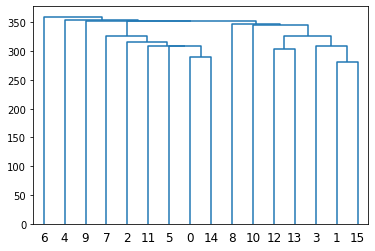

In [17]:
dn = hierarchy.dendrogram(linkage_table)

In [18]:
#Using max distance to perform the clustering

c1_max = 0
c2_max = 1


linkage_table = []
index = 0

n = len(cluster_list_max)
while(len(cluster_list_max)!=1):
   
    min_val = 10000
    for i in dictionary_max:
        key_list = list(dictionary_max[i].keys())
        if(min(dictionary_max[i].values()) < min_val):
            c1_max = i
            c2_max = [k for k, v in dictionary_max[i].items() if v == min(dictionary_max[i].values())][0]
            
            min_val = min(dictionary_max[i].values())
            
   
    linkage_table.append([cluster_map_max[c1_max],cluster_map_max[c2_max],min_val,cluster_count_max[c1_max]+cluster_count_max[c2_max]])
    cluster_count_max[(c1_max,c2_max)] = cluster_count_max[c1_max]+cluster_count_max[c2_max]
    
   
    cluster_map_max[(c1_max,c2_max)] = n+index
    index+=1
    
   
    for i in cluster_list_max:
        lance_williams_dist(c1_max,c2_max,i,dictionary_max,0.5,0.5,0,0.5)
    
   
    cluster_list_max.append((c1_max,c2_max))
    
 
    del dictionary_max[c1_max]
    del dictionary_max[c2_max]
    
  
    keys = list(dictionary_max.keys())
    for i in keys:
        try:
            if(i!=c1_max or c1_max not in i):
                del dictionary_max[i][c1_max]
            if(i!=c2_max or c2_max not in i):
                del dictionary_max[i][c2_max]
        except KeyError:
            print("key previously removed")
    
    cluster_list_max.remove(c1_max)
    cluster_list_max.remove(c2_max)
    
    

key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed


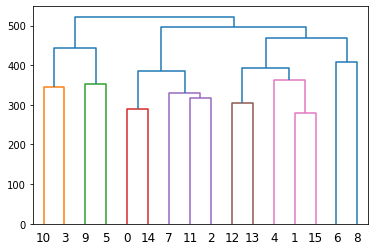

In [19]:
linkage_table=np.array([np.array(xi) for xi in linkage_table])

dn = hierarchy.dendrogram(linkage_table)

In [20]:
#Using AVG as clustering method to agglormerate 

import math

c1_avg = 0
c2_avg = 1

c1_size = 0
c2_size = 0

linkage_table = []
index = 0

while(len(cluster_list_avg)!=1):
    
    min_val = math.inf
    for i in dictionary_avg:
        key_list = list(dictionary_avg[i].keys())
        if(min(dictionary_avg[i].values()) < min_val):
            c1_avg = i
            c2_avg = [k for k, v in dictionary_avg[i].items() if v == min(dictionary_avg[i].values())][0]
            min_val = min(dictionary_avg[i].values())
            
    
    linkage_table.append([cluster_map_avg[c1_avg],cluster_map_avg[c2_avg],min_val,cluster_count_avg[c1_avg]+cluster_count_avg[c2_avg]])
    cluster_count_avg[(c1_avg,c2_avg)] = cluster_count_avg[c1_avg]+cluster_count_avg[c2_avg]
    
    
    cluster_map_avg[(c1_avg,c2_avg)] = n+index
    index+=1

    
    for i in cluster_list_avg:
        lance_williams_dist(c1_avg,c2_avg,i,dictionary_avg,cluster_count[c1_avg],cluster_count[c2_avg],0,0.5)
    
    
    cluster_list_avg.append((c1_avg,c2_avg))
    cluster_count[(c1_avg, c2_avg)] = cluster_count[c1_avg]+cluster_count[c2_avg]
    
    del dictionary_avg[c1_avg]
    del dictionary_avg[c2_avg]
    
    
    keys = list(dictionary_avg.keys())
    for i in keys:
        try:
            if(i!=c1_avg or c1_avg not in i):
                del dictionary_avg[i][c1_avg]
            if(i!=c2_avg or c2_avg not in i):
                del dictionary_avg[i][c2_avg]
        except KeyError:
            print("key previously removed")
    
    cluster_list_avg.remove(c1_avg)
    cluster_list_avg.remove(c2_avg)
    
    # print("c1_max and c2_max removed")

key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed
key previously removed


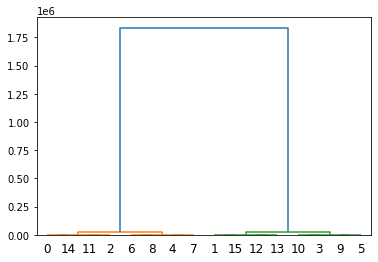

In [21]:
linkage_table=np.array([np.array(xi) for xi in linkage_table])
dn = hierarchy.dendrogram(linkage_table)